# Logbook Blocking 

An implementation of the network-based blocking mechanism

In [1]:
%matplotlib inline
import os 
import sys
import random
import networkx as nx 

## Paths from the file 
PROJECT  = os.path.join(os.getcwd(), "..")
FIXTURES = os.path.join(PROJECT, "fixtures")
DATASET  = os.path.join(FIXTURES, 'activity.csv')

## Append the path for the logbook utilities 
sys.path.append(PROJECT)

from logbook.reader import LogReader 
from logbook.graph import *
from logbook.compare import * 

In [2]:
# Actions to exclude from our graph. 
# exclude = None
exclude=['Subscribed to DDL blog', 'Signed up for new course notifications']

# Load dataset and generate graph
dataset = LogReader(DATASET, exclude=exclude)
G = graph_from_triples(dataset)

print info(G)

Name: Logbook Activity
Type: Graph
Number of nodes: 548
Number of edges: 623
Average degree:   2.2737
Number of Actions: 7
Number of Pairwise Comparisons: 149878
Number of Edge Blocked Comparisons: 136377

Action Counts
-------------
Registered for workshop: 352
Applied to DDL incubator: 198
Applied to DDL research lab: 25
Taught workshop: 16
Organized workshop: 12
Wrote blog post: 12
TA for workshop: 8


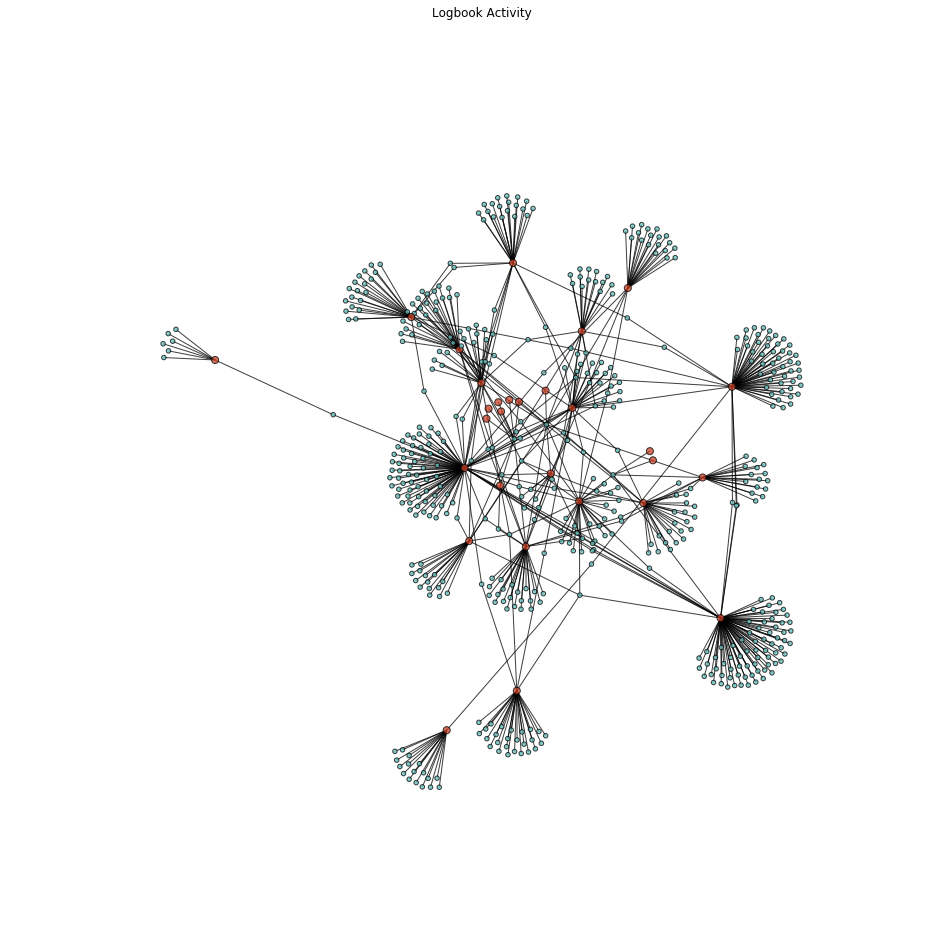

In [3]:
draw_activity_graph(G, connected=True)

## Graph Structured Pairwise Comparisons 

By implementing a graph where person entity nodes are a tuple of `(name, email)` pairs (an immutable data structure that is hashable), we get structure right off the bat by direct comparison. 

The number of pariwise comparisons is computed as: 

$$c = \frac{n(n-1)}{2}$$

Where `n` is the number of nodes in the graph. The graph can be further filtered on entity type as well. Here are a random sample of 5 pairwise node to node comparisons: 

In [4]:
print "Pairwise Comparisons: {}\n\n".format(pairwise_comparisons(G, True))

combos = list(pairwise_comparisons(G, entity='person'))
random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    if idx >= 4: break

Pairwise Comparisons: 149878


Pair 1:
    Entity(name=u'Jamie Yachera', email=u'rileyjx@yahoo.com')
      -- vs --
    Entity(name=u'Donald Besong', email=u'donald.besong@yahoo.co.uk')
Pair 2:
    Entity(name=u'Christopher Selmer', email=u'cmselmer@gmail.com')
      -- vs --
    Entity(name=u'James Miraflor', email=u'james.miraflor@gmail.com')
Pair 3:
    Entity(name=u'Travis Pinney', email=u'travis@tlpsystems.com')
      -- vs --
    Entity(name=u'Christopher Smith', email=u'smith_c@icloud.com')
Pair 4:
    Entity(name=u'Laura Lorenz', email=u'lalorenz6@gmail.com')
      -- vs --
    Entity(name=u'Mark Silverberg', email=u'mark@marksilver.net')
Pair 5:
    Entity(name=u'Hannah Dean', email=u'hdean83@gmail.com')
      -- vs --
    Entity(name=u'Andrew Stevens', email=u'acstevens@hotmail.com')


Edge structured comparisons only yield nodes so long as the itersection of the node's neighborhoods is empty (that is, two entities can't have an action to the same detail). 

In [5]:
print "Edge Blocked Pairwise Comparisons: {}\n\n".format(edge_blocked_comparisons(G, True))

combos = list(edge_blocked_comparisons(G, entity='person'))
random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    
    print "      Connections: "

    neighbors = set(G.neighbors(pair[0])) - set(G.neighbors(pair[1]))
    for n in neighbors:
        print "        {}".format(n)
    if idx >= 4: break

Edge Blocked Pairwise Comparisons: 136377


Pair 1:
    Entity(name=u'Wayne Liu', email=u'wliu30@jhu.edu')
      -- vs --
    Entity(name=u'Alireza Yazdani', email=u'alirezayazdani21@yahoo.com')
      Connections: 
        Detail(detail=u'Incubator 3 - Accepted')
Pair 2:
    Entity(name=u'Srinath Neelamegam', email=u'srinath.np@gmail.com')
      -- vs --
    Entity(name=u'Charles Greenbacker', email=u'greenbacker@gmail.com')
      Connections: 
        Detail(detail=u'Intro to R')
Pair 3:
    Entity(name=u'Abhishek Sharma', email=u'absharma@gmail.com')
      -- vs --
    Entity(name=u'Dennis Murakhovskiy', email=u'denmur@impactresearchinc.com')
      Connections: 
        Detail(detail=u'Incubator 3 - Accepted')
Pair 4:
    Entity(name=u'Craig Brown', email=u'browncp@jmu.edu')
      -- vs --
    Entity(name=u'Konstantinos Xirogiannopoulos', email=u'kostasxirog91@gmail.com')
      Connections: 
        Detail(detail=u'Building Data Apps with Python')
Pair 5:
    Entity(name=u'Paranjai S

Other structural blocking can then be applied. 

## Fuzziness 

With some blocking in the data structure, we can now begin to do pairwise comparisons. Here, I'll use the `fuzzywuzzy` tool to produce comparisons for the annotator such that the mean of the fuzzy score for both email and name meets a certain threshold. 

In [6]:
combos = list(edge_blocked_comparisons(G, entity='person'))
combos = filter(lambda pair: fuzzblock(*pair), combos)

print "Fuzz/Edge Blocked Pairwise Comparisons: {}\n\n".format(len(combos))

random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    
    print "      Connections: "

    neighbors = set(G.neighbors(pair[0])) - set(G.neighbors(pair[1]))
    for n in neighbors:
        print "        {}".format(n)
    if idx >= 4: break

Fuzz/Edge Blocked Pairwise Comparisons: 126


Pair 1:
    Entity(name=u'Ryan Smith', email=u'ryansmith@jhu.edu')
      -- vs --
    Entity(name=u'Christopher Smith', email=u'smith_c@icloud.com')
      Connections: 
        Detail(detail=u'Incubator 1')
Pair 2:
    Entity(name=u'Khanh Stenberg', email=u'ben.travis@viget.com')
      -- vs --
    Entity(name=u'Travis Pinney', email=u'travis@tlpsystems.com')
      Connections: 
        Detail(detail=u'Building Data Apps with Python')
Pair 3:
    Entity(name=u'Amanda Traud', email=u'amanda.traud@gmail.com')
      -- vs --
    Entity(name=u'Madan Ram', email=u'madan_ram@rocketmail.com')
      Connections: 
        Detail(detail=u'Analyzing Social Media Data with R')
Pair 4:
    Entity(name=u'Juan Salazar', email=u'juan.salazar.ferro@gmail.com')
      -- vs --
    Entity(name=u'Juan Salazar', email=u'juans@iadb.org')
      Connections: 
        Detail(detail=u'Intro to Machine Learning with Python')
Pair 5:
    Entity(name=u'Rashaad Steward',